# Leverage Calculation of Sections of Image Using Tensorflow #

This code calculates the relative importance of each section of an image using a "leverage" method.

## Define Functions ##

### Function to Return Classification Results for an Image ###
This function returns the classification result based on a trained tensorflow model which uses the inception v3 architecture and an image passed as a numpy array

In [1]:
#Function Inputs:
##image_array - numpy array of dimension: [image width, image height, image channel]. Dimensions must match those expected by the model
##model_graph_path - filepath to a trained tensorflow model graph based on inception v3 architecture. Expects ".pb" format
##model_labels_path - filepath to a trained tensorflow label file based on inception v3 architecture. Expects a ".txt" format

#Function Output:
##Function returns an array with two columns. The first column is the class probability and the second column is the class label

def classify_numpy_image(image_array, model_graph_path, model_labels_path):
    
    #Import required packages
    import tensorflow as tf, sys
    import numpy as np
        
    # Loads label file, strips off carriage return
    label_lines = [line.rstrip() for line 
                       in tf.gfile.GFile(model_labels_path)]
    
    # Unpersists graph from file
    with tf.gfile.FastGFile(model_graph_path, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')
    
    with tf.Session() as sess:
        # Feed the image_data as input to the graph and get first prediction
        softmax_tensor = sess.graph.get_tensor_by_name('final_result:0')
        
        predictions = sess.run(softmax_tensor, \
                 {'DecodeJpeg:0': image_array})
    
    #EricW help on proper format of this output matrix. Would ideally like labeled vector or equivalent that can be coerced into a matrix
    predictionsout = [predictions[0], label_lines]
    
    return predictionsout

### Function to Return Image Leverage ###

This function calculates the "leverage" of each pixel by replacing parts of the image with the average pixel value for the image and classifying the resulting image
This method works as follows:

1. The base image is classified using a trained tensorflow model
2. Parts of the image are replaced by the average pixel value for the image and the resulting modified image is classified
3. The change on the classification result due to replacing parts of the image are quantified and returned as an array of importance for each pixel of the image using this replacement method
4. The relative importance array is returned for each possible image class in the tensorflow model

In [2]:
#Function Inputs:
##image_array - numpy array of dimension: [image width, image height, image channel]. Dimensions must match those expected by the model
##model_graph_path - filepath to a trained tensorflow model graph based on inception v3 architecture. Expects ".pb" format
##width_divisions - the number of horizontal segments to split the image into for leverage calculations
##height_divisions - the number of horizontal segments to split the image into for leverage calculations


#Function Output:
##Function returns an array of numpy arrays, with one array per class defined in the tensorflow model.
##       Each sub-array represents the classification percentage of the image with this pixel blocked out and replaced by the average image value

def image_subsection_classify(image_array, model_graph_path, width_divisions, height_divisions):
    
    #Import required packages
    import tensorflow as tf, sys
    import numpy as np
    from PIL import Image
    
    # Unpersists tensorflow graph from file
    with tf.gfile.FastGFile(model_graph_path, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')
        
    #Start tensorflow session
    sess = tf.Session()
    
    #Get tensor name for final classification result. This may need to change with a non inception v3 model since the last layer name may change
    softmax_tensor = sess.graph.get_tensor_by_name('final_result:0')

    
    original_class = sess.run(softmax_tensor, \
                 {'DecodeJpeg:0': image_array})[0]
    
    ##Calculates the initial classification for the unmodified image
    #original_class = classify_numpy_image(image_array= image_array, model_graph_path = model_graph_path, model_labels_path = model_labels_path)
    
    #Retrieve the image dimensions
    numclasses = np.shape(original_class)
    
    #Calculate average for each channel
    channelaverages = np.mean(image_array, axis = (0,1))
    
    #Calculate step sizes in pixels width
    pixelheight = np.shape(image_array)[0]/height_divisions
    pixelwidth = np.shape(image_array)[1]/width_divisions
    
    #Create the output array structure with height, width, and number of tensorflow model classes as dimensions
    #output_array = np.zeros((np.shape(image_array)[0], np.shape(image_array)[1], numclasses[1]))
    output_array = np.zeros((np.shape(image_array)[0], np.shape(image_array)[1], numclasses[0]))
    
    # Load tensorflow label file, strips off carriage return
    #label_lines = [line.rstrip() for line 
    #                   in tf.gfile.GFile(model_labels_path)]
    
    for i in range(0,(width_divisions)):
        
        for j in range(0,(height_divisions)):
            
            #Calculate pixel values for start and finish for this image segment
            tempwidthstart = int(np.trunc(pixelwidth*i))
            tempwidthend = int(np.trunc(pixelwidth*(i+1)))
            tempheightstart = int(np.trunc(pixelheight*j))
            tempheightend = int(np.trunc(pixelheight*(j+1)))
            
            #Replace part of image with average pixel value
            temp_array = image_array.copy()
            temp_array[tempheightstart:tempheightend,tempwidthstart:tempwidthend,0:np.shape(channelaverages)[0]] = channelaverages
            
            #Classify temporary image and place results for each class into array for affected pixels
            output_array[tempheightstart:tempheightend,tempwidthstart:tempwidthend,:] = sess.run(softmax_tensor, \
                 {'DecodeJpeg:0': temp_array})[0]
            
            
    #Close tensorflow session to release resources
    sess.close()
    
    return output_array

## Set Image, model path, and class number to plot below ##

In [3]:

#Import libraries needed to convert image to array
import tensorflow as tf
import numpy as np
from PIL import Image

#Use tensorflow library to import to ensure correct number of dimensions are used
#In particular, make sure the number of channels matches what the model expects
with tf.Session() as sess:
    imagefile = tf.read_file('testimages/football.png')
    image_tensor = tf.image.decode_image(imagefile, channels = 3)
    image_array = image_tensor.eval()

#Filepaths to trained model files
model_graph_path = 'output_graph_football.pb'
model_labels_path = 'output_labels_football.txt'

#Class index to print for images below
classnum = 1


Check the image array size to make sure it matches what the model expects

In [4]:
np.shape(image_array)

(299, 299, 3)

In [5]:
#Example usage of classfication function above for a single image

original_class = classify_numpy_image(image_array= image_array, model_graph_path = model_graph_path, model_labels_path = model_labels_path)

In [6]:
original_class

[array([ 0.01323347,  0.98676658], dtype=float32), ['good', 'football']]

In [7]:
#Example usage of leverage function above

leverage_array = image_subsection_classify(image_array= image_array, model_graph_path = model_graph_path, height_divisions = 4, width_divisions = 4)

Show one column of a class of resulting leverage frame

In [8]:
leverage_array[:,1,classnum]

array([ 0.98003781,  0.98003781,  0.98003781,  0.98003781,  0.98003781,
        0.98003781,  0.98003781,  0.98003781,  0.98003781,  0.98003781,
        0.98003781,  0.98003781,  0.98003781,  0.98003781,  0.98003781,
        0.98003781,  0.98003781,  0.98003781,  0.98003781,  0.98003781,
        0.98003781,  0.98003781,  0.98003781,  0.98003781,  0.98003781,
        0.98003781,  0.98003781,  0.98003781,  0.98003781,  0.98003781,
        0.98003781,  0.98003781,  0.98003781,  0.98003781,  0.98003781,
        0.98003781,  0.98003781,  0.98003781,  0.98003781,  0.98003781,
        0.98003781,  0.98003781,  0.98003781,  0.98003781,  0.98003781,
        0.98003781,  0.98003781,  0.98003781,  0.98003781,  0.98003781,
        0.98003781,  0.98003781,  0.98003781,  0.98003781,  0.98003781,
        0.98003781,  0.98003781,  0.98003781,  0.98003781,  0.98003781,
        0.98003781,  0.98003781,  0.98003781,  0.98003781,  0.98003781,
        0.98003781,  0.98003781,  0.98003781,  0.98003781,  0.98

Now calculate the change in class for each pixel vs. the classification result for the unmasked original image

In [9]:
#Make a copy of the leverage array to subtract the mean value
change_array = leverage_array.copy()

#Subtract the leverage result matrix from the overall original classification result
#to get the overall classification change from masking areas of the image
for i in range(0,(np.shape(leverage_array)[2])):
    
    change_array[:,:,i] = original_class[0][i] - change_array[:,:,i]
    

In [10]:
print(original_class)
change_array[:,1,classnum]

[array([ 0.01323347,  0.98676658], dtype=float32), ['good', 'football']]


array([ 0.00672877,  0.00672877,  0.00672877,  0.00672877,  0.00672877,
        0.00672877,  0.00672877,  0.00672877,  0.00672877,  0.00672877,
        0.00672877,  0.00672877,  0.00672877,  0.00672877,  0.00672877,
        0.00672877,  0.00672877,  0.00672877,  0.00672877,  0.00672877,
        0.00672877,  0.00672877,  0.00672877,  0.00672877,  0.00672877,
        0.00672877,  0.00672877,  0.00672877,  0.00672877,  0.00672877,
        0.00672877,  0.00672877,  0.00672877,  0.00672877,  0.00672877,
        0.00672877,  0.00672877,  0.00672877,  0.00672877,  0.00672877,
        0.00672877,  0.00672877,  0.00672877,  0.00672877,  0.00672877,
        0.00672877,  0.00672877,  0.00672877,  0.00672877,  0.00672877,
        0.00672877,  0.00672877,  0.00672877,  0.00672877,  0.00672877,
        0.00672877,  0.00672877,  0.00672877,  0.00672877,  0.00672877,
        0.00672877,  0.00672877,  0.00672877,  0.00672877,  0.00672877,
        0.00672877,  0.00672877,  0.00672877,  0.00672877,  0.00

Import utilities needed to plot images and plot sample leverage layer results

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

Plot Image Array

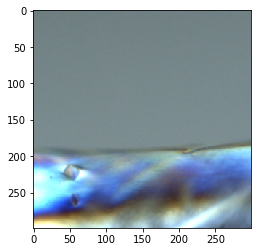

In [12]:
plt.imshow(image_array)

Plot first class of leverage array. Remember that a high value in the leverage matrix means the class probability is high with the section blocked out and a low value in the leverage matrix means the class probability is low with the section blocked out.

football
0.986767


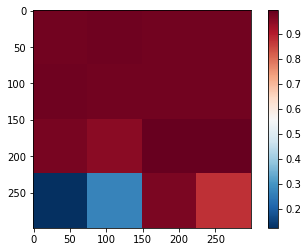

In [13]:
plt.imshow(leverage_array[:,:,classnum], 'RdBu_r')
plt.colorbar()

#Print the name and overall classification result
#for the class under investigation
print(original_class[1][classnum])
print(original_class[0][classnum])

Now, let's create an overlay of the leverage heatmap on the original image to better visualize the effects. Adjust the alpha value as necessary for transparency of the leverage matrix.

football
0.986767


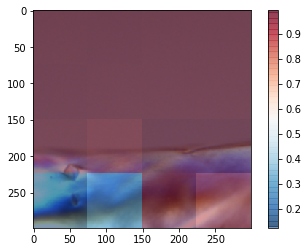

In [14]:
plt.imshow(image_array)
plt.imshow(leverage_array[:,:,classnum], cmap= 'RdBu_r', alpha= 0.5)
plt.colorbar()

#Print the name and overall classification result
#for the class under investigation
print(original_class[1][classnum])
print(original_class[0][classnum])

Plot class change array. Remember that a positive value in the change matrix means the class probability has gone down with the section blocked out and a negative value in the class change matrix means the class probability has gone up with the section blocked out.

football
0.986767


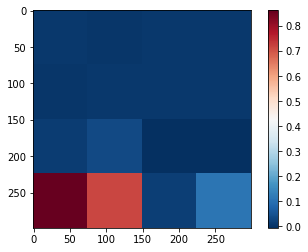

In [15]:
plt.imshow(change_array[:,:,classnum], 'RdBu_r')
plt.colorbar()

#Print the name and overall classification result
#for the class under investigation
print(original_class[1][classnum])
print(original_class[0][classnum])

Now, let's create an overlay of the change heatmap on the original image to better visualize the effects. Adjust the alpha value as necessary for transparency of the change matrix.

football
0.986767


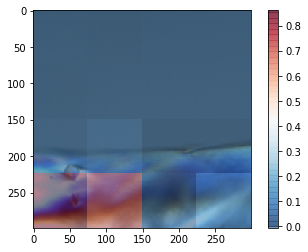

In [16]:
plt.imshow(image_array)
plt.imshow(change_array[:,:,classnum], cmap= 'RdBu_r', alpha= 0.5)
plt.colorbar()

#Print the name and overall classification result
#for the class under investigation
print(original_class[1][classnum])
print(original_class[0][classnum])